In [1]:
import re
import json
import numpy as np
import pandas as pd
from pprint import pprint
import seaborn as sns

# NLTK Stop words
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

# spacy for lemmatization
import spacy

#remove urls, mentions, emojis 
import preprocessor as p

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  
import matplotlib.pyplot as plt

In [2]:
filepath = '/Users/lavine/Desktop/Terriers!/misinformation project/data/data.txt'

### Create a dataframe by every columns

In [3]:
#load all the JSON objects in one list as dictionaries
data = []
with open(filepath,'r') as f:
    for line in f:
        data.append(json.loads(line))

In [4]:
data[2]['referenced_tweets'][0]['text']

"I'm thinking about writing a satire where the U.S. Congress is blocked from taking action on the climate by a Senator who owns a coal company, lives on a yacht and speaks daily with Exxon lobbyists -- but I'm worried people will think it's too on the nose. 😔"

In [5]:
data[4]['referenced_tweets']

[{'type': 'retweeted',
  'id': '1476696095963058177',
  'lang': 'en',
  'possibly_sensitive': False,
  'author_id': '2181341294',
  'text': '@ScottGrimnes @MaMan564 @SoFarFletched ‘We’ started calling it ‘climate change’ when Exxon Mobile did a very successful PR campaign in the 90’s. Apparently ‘global warming’ is too specific and scary. But It’s global warming. https://t.co/WPetiWDQG3',
  'entities': {'annotations': [{'start': 85,
     'end': 96,
     'probability': 0.581,
     'type': 'Organization',
     'normalized_text': 'Exxon Mobile'}],
   'urls': [{'start': 225,
     'end': 248,
     'url': 'https://t.co/WPetiWDQG3',
     'expanded_url': 'http://Exxonknew.org',
     'display_url': 'Exxonknew.org'}],
   'mentions': [{'start': 0,
     'end': 13,
     'username': 'ScottGrimnes',
     'id': '847597746043342848',
     'verified': False,
     'created_at': '2017-03-30T23:53:45.000Z',
     'location': 'Arizona, USA',
     'public_metrics': {'followers_count': 357,
      'following_co

 #### Put the text data in one list

not original:
referenced_tweet in i:
 == retweet 
 
lst_


original:
if not 'referenced_tweets' in i

lst_o_text.append(i['text'])



#retrive text and avoid truncated text when retweet without quoting
lst_o_text = []
lst_ret_text = []
lst_rep_text = []

for i in data:    
    if 'referenced_tweets' in i:
        if i['referenced_tweets'][0]['type'] != 'retweeted':
            lst_text.append(i['referenced_tweets'][0]['text'])
        else:
            lst_text.append(i['text'])
    else:
        lst_text.append(i['text'])

In [6]:
lst_o_text = []

#create lists for id, author id and conversation
lst_id = []
lst_lang = []
lst_author_id = []
lst_conversation_id = []

#lst verified or not, author name and author username
lst_author_verified = []
lst_author_name = []
lst_author_username = []

#list creation time
lst_twt_creation_time = []

for i in data:
    if not 'referenced_tweets' in i:
        lst_o_text.append(i['text'])
        lst_id.append(i['id'])
        lst_lang.append(i['lang'])
        lst_author_id.append(i['author_id'])
        lst_conversation_id.append(i['conversation_id'])
        lst_author_verified.append(i['author']['verified'])
        lst_author_name.append(i['author']['name'])
        lst_author_username.append(i['author']['username'])
        lst_twt_creation_time.append(i['created_at'])

 #### Put the author info in list

In [7]:
data[0].keys()

dict_keys(['lang', 'id', 'possibly_sensitive', 'author_id', 'text', 'referenced_tweets', 'created_at', 'source', 'entities', 'in_reply_to_user_id', 'reply_settings', 'conversation_id', 'public_metrics', 'author', 'in_reply_to_user', '__twarc'])

 ##### 'id', 'author_id', 'conversation_id', 'author'

#create lists for id, author id and conversation
lst_id = []
lst_lang = []
lst_author_id = []
lst_conversation_id = []
for i in data:
    lst_id.append(i['id'])
    lst_lang.append(i['lang'])
    lst_author_id.append(i['author_id'])
    lst_conversation_id.append(i['conversation_id'])

There are too much info in author dictionary

#lst verified or not, author name and author username
lst_author_verified = []
lst_author_name = []
lst_author_username = []
for i in data:
    lst_author_verified.append(i['author']['verified'])
    lst_author_name.append(i['author']['name'])
    lst_author_username.append(i['author']['username'])

 ##### Make creation time

#list creation time
lst_twt_creation_time = []
for i in data:
    lst_twt_creation_time.append(i['created_at'])

##### Put what we have in one dataframe

lst_text,lst_id, lst_author_id,lst_conversation_id,lst_author_verified, lst_author_name, lst_author_username,lst_twt_creation_time

In [8]:
tweets = pd.DataFrame({'text': lst_o_text,
                  'language': lst_lang,
                  'id': lst_id,
                  'author_id': lst_author_id,
                  'conversation_id': lst_conversation_id,
                  'author_verified': lst_author_verified,
                  'author_name': lst_author_name,
                  'author_username': lst_author_username,
                  'twt_creation_time': lst_twt_creation_time
                  })

In [9]:
pd.set_option("display.max_colwidth", 10000)

In [10]:
tweets.drop(tweets[tweets['language'] != 'en'].index, inplace = True)

In [11]:
tweets.head()

,text,language,id,author_id,conversation_id,author_verified,author_name,author_username,twt_creation_time
0,"'We are in a climate emergency'December wildfires ravage Colorado https://t.co/sWDkZM4Rvn Sen. Manchin, your Exxon highway bill isn't going 2save our homes or our lives,"" ""Your greed &amp; corruption is not only torching our future It's burning our communities and destroying lives!",en,1477024401254092800,1009831809855688707,1477024401254092800,False,Vammek Opinion,Vammek,2021-12-31T21:10:33.000Z
1,"#Oil business knows about the damage that It does, but this business is too much easy and lucrative https://t.co/W7MemjJAA9 #FossilFuels \nExxon’s Plan for Surging Carbon Emissions Revealed in Leaked Documents https://t.co/RFX8meYv11",en,1476991564803104776,590788952,1476991564803104776,False,Robert Pujol i Vives,rpujolvives,2021-12-31T19:00:04.000Z
2,@amywestervelt Your opinion piece concerning climate science alone motivating people to help create political change on Global Warming policy is Spot On. Informing people about the injustices Exxon and Big Oil has perpetrated on us is crucial in inspiring citizens to fight back.,en,1476962302159060992,1476958634705780736,1476962302159060992,False,Megan Robbins,MeganRo50852817,2021-12-31T17:03:48.000Z
3,"Each year, the government gives over $15 billion in taxpayer-funded subsidies to fossil fuel corporations who contribute to the climate crisis like Exxon. \n\nWill you sign this petition to pressure the Senate to END fossil fuel subsidies https://t.co/2A7wLyid3X?",en,1476954565450903553,47878087,1476954565450903553,False,Jennifer Hall,JDHall_35402,2021-12-31T16:33:03.000Z
4,"Each year, the government gives over $15 billion in taxpayer-funded subsidies to fossil fuel corporations who contribute to the climate crisis like Exxon. \n\nWill you sign our petition to pressure the Senate to END fossil fuel subsidies https://t.co/OD7YqPO5SP?",en,1476922966893948928,1450838788037496836,1476922966893948928,False,Dennis Landi,DennisLandi2,2021-12-31T14:27:29.000Z


### Data preprocessing

In [12]:
tweets['hashtag'] = tweets['text'].apply(lambda x: re.findall(r"#(\w+)", x))

In [13]:
#forming a separate feature for cleaned tweets
tweets['ctext'] = tweets['text'].apply(lambda x: p.clean(x))

In [14]:
tweets.head(3)

,text,language,id,author_id,conversation_id,author_verified,author_name,author_username,twt_creation_time,hashtag,ctext
0,"'We are in a climate emergency'December wildfires ravage Colorado https://t.co/sWDkZM4Rvn Sen. Manchin, your Exxon highway bill isn't going 2save our homes or our lives,"" ""Your greed &amp; corruption is not only torching our future It's burning our communities and destroying lives!",en,1477024401254092800,1009831809855688707,1477024401254092800,False,Vammek Opinion,Vammek,2021-12-31T21:10:33.000Z,[],"'We are in a climate emergency'December wildfires ravage Colorado Sen. Manchin, your Exxon highway bill isn't going save our homes or our lives,"" ""Your greed &amp; corruption is not only torching our future It's burning our communities and destroying lives!"
1,"#Oil business knows about the damage that It does, but this business is too much easy and lucrative https://t.co/W7MemjJAA9 #FossilFuels \nExxon’s Plan for Surging Carbon Emissions Revealed in Leaked Documents https://t.co/RFX8meYv11",en,1476991564803104776,590788952,1476991564803104776,False,Robert Pujol i Vives,rpujolvives,2021-12-31T19:00:04.000Z,"[Oil, FossilFuels]","business knows about the damage that It does, but this business is too much easy and lucrative Exxons Plan for Surging Carbon Emissions Revealed in Leaked Documents"
2,@amywestervelt Your opinion piece concerning climate science alone motivating people to help create political change on Global Warming policy is Spot On. Informing people about the injustices Exxon and Big Oil has perpetrated on us is crucial in inspiring citizens to fight back.,en,1476962302159060992,1476958634705780736,1476962302159060992,False,Megan Robbins,MeganRo50852817,2021-12-31T17:03:48.000Z,[],Your opinion piece concerning climate science alone motivating people to help create political change on Global Warming policy is Spot On. Informing people about the injustices Exxon and Big Oil has perpetrated on us is crucial in inspiring citizens to fight back.


In [15]:
#convert to list
ctext = tweets['ctext'].tolist()

In [16]:
# Remove new line characters
ctext = [re.sub('\s+', ' ', sent) for sent in ctext]

<>:2: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
/var/folders/kg/0ndh6pln2x7b6rpm16twhvpc0000gn/T/ipykernel_22134/1351202947.py:2: DeprecationWarning: invalid escape sequence \s
  ctext = [re.sub('\s+', ' ', sent) for sent in ctext]


In [17]:
# Remove distracting single quotes
ctext = [re.sub("\'", "", sent) for sent in ctext]

In [18]:
# remove punctuations
ctext = [re.sub(r'[^\w\s]', '', sent) for sent in ctext]

In [19]:
ctext[1:5]

['business knows about the damage that It does but this business is too much easy and lucrative Exxons Plan for Surging Carbon Emissions Revealed in Leaked Documents',
 'Your opinion piece concerning climate science alone motivating people to help create political change on Global Warming policy is Spot On Informing people about the injustices Exxon and Big Oil has perpetrated on us is crucial in inspiring citizens to fight back',
 'Each year the government gives over 15 billion in taxpayerfunded subsidies to fossil fuel corporations who contribute to the climate crisis like Exxon Will you sign this petition to pressure the Senate to END fossil fuel subsidies ',
 'Each year the government gives over 15 billion in taxpayerfunded subsidies to fossil fuel corporations who contribute to the climate crisis like Exxon Will you sign our petition to pressure the Senate to END fossil fuel subsidies ']

### Tokenize words and further clean up text

In [20]:
#tokenize each sentence into a list of words, removing punctuations and unnecessary characters altoghter

In [21]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

tweet_words = list(sent_to_words(ctext))

print(tweet_words[:1])

[['we', 'are', 'in', 'climate', 'wildfires', 'ravage', 'colorado', 'sen', 'manchin', 'your', 'exxon', 'highway', 'bill', 'isnt', 'going', 'save', 'our', 'homes', 'or', 'our', 'lives', 'your', 'greed', 'amp', 'corruption', 'is', 'not', 'only', 'torching', 'our', 'future', 'its', 'burning', 'our', 'communities', 'and', 'destroying', 'lives']]


In [22]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tweet_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tweet_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[tweet_words[0]]])

['we', 'are', 'in', 'climate', 'wildfires', 'ravage', 'colorado', 'sen_manchin', 'your', 'exxon', 'highway', 'bill', 'isnt', 'going', 'save', 'our', 'homes', 'or', 'our', 'lives', 'your', 'greed', 'amp', 'corruption', 'is', 'not', 'only', 'torching', 'our', 'future', 'its', 'burning', 'our', 'communities', 'and', 'destroying', 'lives']


### Remove Stopwords, Make Bigrams and Lemmatize

In [57]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'm', 'climate'])

In [58]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [59]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [60]:
# Remove Stop Words
tweet_words_nostops = remove_stopwords(tweet_words)

In [61]:
# Form Bigrams
tweet_words_bigrams = make_bigrams(tweet_words_nostops)

In [62]:
# Initialize spacy 'en_core_web_sm' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])# not "en" any more

# Do lemmatization keeping only noun, adj, vb, adv
tweet_lemmatized = lemmatization(tweet_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(tweet_lemmatized[:1])

[['wildfire', 'ravage', 'highway', 'bill', 'go', 'save', 'home', 'live', 'greed', 'amp', 'corruption', 'torch', 'future', 'burn', 'community', 'destroy', 'life']]


### Creat the dictionary and the corpus

In [63]:
# Create Dictionary
id2word = corpora.Dictionary(tweet_lemmatized)

# Create Corpus
texts = tweet_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts] 

#Gensim creates a unique id for each word in the document. 
#The produced corpus shown below is a mapping of (word_id, word_frequency(times of occurance)).

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]]


In [64]:
id2word[40]

'motivate'

In [65]:
#If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.
id2word[4]

#in put of LDA

'corruption'

In [66]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('amp', 1),
  ('bill', 1),
  ('burn', 1),
  ('community', 1),
  ('corruption', 1),
  ('destroy', 1),
  ('future', 1),
  ('go', 1),
  ('greed', 1),
  ('highway', 1),
  ('home', 1),
  ('life', 1),
  ('live', 1),
  ('ravage', 1),
  ('save', 1),
  ('torch', 1),
  ('wildfire', 1)]]

### Building the Topic Model

In [67]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=200,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [68]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.064*"oil" + 0.042*"big" + 0.041*"activist" + 0.033*"new" + '
  '0.032*"investor" + 0.029*"board" + 0.028*"company" + 0.016*"use" + '
  '0.015*"giant" + 0.015*"energy"'),
 (1,
  '0.054*"crisis" + 0.043*"fuel" + 0.036*"fossil" + 0.035*"vote" + '
  '0.031*"face" + 0.026*"pressure" + 0.020*"keep" + 0.017*"world" + '
  '0.016*"role" + 0.012*"evil"'),
 (2,
  '0.076*"change" + 0.016*"know" + 0.014*"shareholder" + 0.014*"back" + '
  '0.014*"amp" + 0.013*"win" + 0.012*"shell" + 0.011*"hold" + 0.011*"say" + '
  '0.010*"technology"'),
 (3,
  '0.076*"exxon" + 0.055*"emission" + 0.025*"plan" + 0.023*"business" + '
  '0.022*"strategy" + 0.016*"time" + 0.015*"need" + 0.015*"reveal" + '
  '0.015*"investment" + 0.014*"cut"')]


### Compute model perplexity and coherence score

In [69]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tweet_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.789235030433813

Coherence Score:  0.2835521626373156


In [70]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: t

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.006024 -0.345976       1        1  36.670798
0     -0.346110  0.115922       2        1  35.283969
1      0.141301  0.061324       3        1  14.633585
3      0.198784  0.168730       4        1  13.411648, topic_info=                 Term         Freq        Total Category  logprob  loglift
29             change  5694.000000  5694.000000  Default  30.0000  30.0000
41                oil  4590.000000  4590.000000  Default  29.0000  29.0000
20              exxon  2065.000000  2065.000000  Default  28.0000  28.0000
28                big  3038.000000  3038.000000  Default  27.0000  27.0000
52             crisis  1604.000000  1604.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
175            target   214.177765   218.596382   Topic4  -4.8463   1.9886
17           business   614.292095   802.225731   Topic4  -3.7926   1.7421
11056       reversing   195.016663   201.782149   Topic4  -4.9400   1.9749
11055  quietly_shelve   189.533271   195.670441   Topic4  -4.9685   1.9772
92                put   237.090916   377.665672   Topic4  -4.7446   1.5435

[176 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
63        1  0.558719    action
63        3  0.440361    action
172       2  0.999835  activist
157       2  0.997257        ad
931       1  0.998645   address
...     ...       ...       ...
3040      4  0.995634      wind
206       3  0.998641     world
778       2  0.997208       xom
62        1  0.659448      year
62        3  0.340162      year

[170 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4])

# The Following code is still being working on

### Find the optimal number of topics

In [71]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [72]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=tweet_lemmatized, start=2, limit=20, step=2)

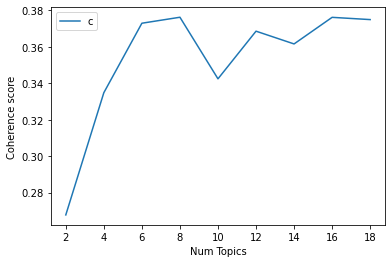

In [73]:
# Show graph
limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [74]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2677
Num Topics = 4  has Coherence Value of 0.3348
Num Topics = 6  has Coherence Value of 0.3729
Num Topics = 8  has Coherence Value of 0.3762
Num Topics = 10  has Coherence Value of 0.3424
Num Topics = 12  has Coherence Value of 0.3685
Num Topics = 14  has Coherence Value of 0.3615
Num Topics = 16  has Coherence Value of 0.3761
Num Topics = 18  has Coherence Value of 0.3749


In [75]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.059*"activist" + 0.045*"change" + 0.042*"board" + 0.039*"investor" + '
  '0.027*"oil" + 0.023*"new" + 0.021*"win" + 0.019*"shareholder" + '
  '0.019*"company" + 0.017*"emission"'),
 (1,
  '0.031*"crisis" + 0.028*"downplay" + 0.027*"use" + 0.026*"say" + '
  '0.025*"engine" + 0.022*"change" + 0.019*"study" + 0.018*"action" + '
  '0.016*"find" + 0.016*"company"'),
 (2,
  '0.031*"change" + 0.015*"amp" + 0.015*"back" + 0.012*"make" + 0.012*"get" + '
  '0.011*"hold" + 0.010*"say" + 0.009*"blow" + 0.008*"need" + 0.008*"exxon"'),
 (3,
  '0.056*"historic" + 0.044*"director" + 0.028*"investor_oust" + '
  '0.028*"science" + 0.026*"proclimate_campaign" + 0.020*"evil" + 0.016*"lie" '
  '+ 0.013*"proposal" + 0.012*"tobacco" + 0.012*"wall_street"'),
 (4,
  '0.061*"seat" + 0.041*"lobbyist" + 0.030*"push" + 0.029*"exxon" + '
  '0.028*"video" + 0.027*"effort" + 0.017*"action" + 0.017*"strategy" + '
  '0.017*"hedge_fund" + 0.016*"catch"'),
 (5,
  '0.097*"fuel" + 0.090*"fossil" + 0.064*"pressure

In [76]:
# Visualize the optimal topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
vis

/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.185280  0.041315       1        1  18.965650
2     -0.102567  0.046607       2        1  18.170282
6     -0.152754 -0.032758       3        1  17.797062
1     -0.086116 -0.094592       4        1  12.126617
4     -0.009829  0.170066       5        1  12.047285
5      0.107062 -0.269516       6        1   8.860379
7      0.214690  0.179283       7        1   7.161237
3      0.214794 -0.040404       8        1   4.871488, topic_info=          Term         Freq        Total Category  logprob  loglift
55        fuel  2034.000000  2034.000000  Default  30.0000  30.0000
54      fossil  1864.000000  1864.000000  Default  29.0000  29.0000
41         oil  4388.000000  4388.000000  Default  28.0000  28.0000
2827      seat  1498.000000  1498.000000  Default  27.0000  27.0000
172   activist  2484.000000  2484.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
826       week   104.245687   389.185436   Topic8  -4.5536   1.7045
34       fight    99.330470   977.564974   Topic8  -4.6019   0.7352
969    serious    56.593981    96.770285   Topic8  -5.1644   2.4853
86    industry    68.394852  1043.851945   Topic8  -4.9750   0.2964
66     company    57.724902  2421.922442   Topic8  -5.1446  -0.7149

[508 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1602      1  0.061421       accord
1602      4  0.818950       accord
1602      7  0.102369       accord
1725      2  0.923049  accountable
1725      3  0.061084  accountable
...     ...       ...          ...
62        7  0.002959         year
62        8  0.004931         year
2446      4  0.916223    yesterday
2446      5  0.081644    yesterday
2191      3  0.985826    york_time

[1208 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 7, 2, 5, 6, 8, 4])

### Finding the dominant topic in each sentence

In [77]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=ctext):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=ctext)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.3479,"plan, business, exxon, sue, emission, dutch, time, know, damage, reveal",We are in a climate emergencyDecember wildfires ravage Colorado Sen Manchin your Exxon highway bill isnt going save our homes or our lives Your greed amp corruption is not only torching our future Its burning our communities and destroying lives
1,1,7.0,0.9204,"plan, business, exxon, sue, emission, dutch, time, know, damage, reveal",business knows about the damage that It does but this business is too much easy and lucrative Exxons Plan for Surging Carbon Emissions Revealed in Leaked Documents
2,2,0.0,0.7950,"activist, change, board, investor, oil, new, win, shareholder, company, emission",Your opinion piece concerning climate science alone motivating people to help create political change on Global Warming policy is Spot On Informing people about the injustices Exxon and Big Oil has perpetrated on us is crucial in inspiring citizens to fight back
3,3,5.0,0.9453,"fuel, fossil, pressure, chevron, year, corporation, end, petition, subsidy, crisis",Each year the government gives over 15 billion in taxpayerfunded subsidies to fossil fuel corporations who contribute to the climate crisis like Exxon Will you sign this petition to pressure the Senate to END fossil fuel subsidies
4,4,5.0,0.9453,"fuel, fossil, pressure, chevron, year, corporation, end, petition, subsidy, crisis",Each year the government gives over 15 billion in taxpayerfunded subsidies to fossil fuel corporations who contribute to the climate crisis like Exxon Will you sign our petition to pressure the Senate to END fossil fuel subsidies


### Find the most representative document for each topic

In [78]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(8)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9582,"activist, change, board, investor, oil, new, win, shareholder, company, emission",The next year Exxon completed a comprehensive page internal report on climate change which predicted almost exactly the amount of global warming weve seen as well as sea level rise drought and more Popular Science
1,1.0,0.9516,"crisis, downplay, use, say, engine, change, study, action, find, company",Exxon buys more Facebook ads than any other fossil fuel company A report out this week found that in Exxon has consistently been a top spender on climate issues across the social platform Yes climate issues how strange that sounds
2,2.0,0.9637,"change, amp, back, make, get, hold, say, blow, need, exxon",amazing that Im getting an ad about tackling climate change from Exxon Were researching biofuels to make your package traveling across world produce slightly less carbon maybe we dont need to order packages from across the world supporting local economies or something
3,3.0,0.9416,"historic, director, investor_oust, science, proclimate_campaign, evil, lie, proposal, tobacco, wall_street",Exxon CEO accused of lying about climate science to congressional panelCongresswoman Carolyn Maloney likens oil company bosses responses to those of tobacco industry at historic hearing Environment The Guardian
4,4.0,0.9532,"seat, lobbyist, push, exxon, video, effort, action, strategy, hedge_fund, catch",Exxons ad in The Daily used a common climate misinformation technique called paltering No individual sentence was percent false but together they created a misleading impression of the company and its climate efforts
5,5.0,0.9513,"fuel, fossil, pressure, chevron, year, corporation, end, petition, subsidy, crisis",Each year the government gives over 15 billion in taxpayerfunded subsidies to fossil fuel corporations who contribute to the climate crisis like Exxon Will you sign our petition to pressure the Senate to END fossil fuel subsidies Make them pay
6,6.0,0.9539,"oil, big, change, company, giant, gas, industry, day, shell, chevron",Why are gas prices soaring when oil company costs are low Biden wants answers USA TODAY Unreal So the answer to addressing climate change is to increase oil productiondrilling in the US Thanks Exxon and Chevron
7,7.0,0.9375,"plan, business, exxon, sue, emission, dutch, time, know, damage, reveal",Time to deliver on climate care jobs and justice I urge you to end weeks of obstruction today by passing the full Build Back Better plan before Exxons bipartisan plan We have desperately needed to do this PLEASE


### Topic distribution across documents

In [79]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(8)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,7.0,"plan, business, exxon, sue, emission, dutch, time, know, damage, reveal",4423.0,0.2103
1.0,7.0,"plan, business, exxon, sue, emission, dutch, time, know, damage, reveal",2372.0,0.1128
2.0,0.0,"activist, change, board, investor, oil, new, win, shareholder, company, emission",3708.0,0.1763
3.0,5.0,"fuel, fossil, pressure, chevron, year, corporation, end, petition, subsidy, crisis",941.0,0.0447
4.0,5.0,"fuel, fossil, pressure, chevron, year, corporation, end, petition, subsidy, crisis",3082.0,0.1466
5.0,7.0,"plan, business, exxon, sue, emission, dutch, time, know, damage, reveal",1090.0,0.0518
6.0,5.0,"fuel, fossil, pressure, chevron, year, corporation, end, petition, subsidy, crisis",4052.0,0.1927
7.0,2.0,"change, amp, back, make, get, hold, say, blow, need, exxon",1361.0,0.0647
